# MATHEUS - PRE PROCESSAMENTO E REGRESSÕES LINEARES

## 1. Início:

link: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data

Variável | Descrição
|---------------|-------|
Pregnancies|Número de vezes grávida
Glucose|Concentração de glicose no plasma 2 horas após teste de tolerância à glicose oral
BloodPressure|Pressão arterial diastólica (mm Hg)
SkinThickness|Espessura da dobra cutânea do tríceps (mm)
Insulin|Insulina sérica de 2 horas (mu U/ml) - dosagem de insulina no sangue duas horas após o consumo de uma refeição ou de uma carga de glicose
BMI|Índice de massa corporal (peso em kg/(altura em m)^2)
DiabetesPedigreeFunction|Função que pontua a probabilidade de diabetes com base no histórico familiar. Fornece dados sobre histórico de diabetes mellitus em parentes e a relação genética desses parentes com o paciente.
Age|Idade (anos)
Outcome|"Variável de classe (0 ou 1) 268 de 768 são 1, os outros são 0"

### 1.1 Imports:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1.2 Dataset:

In [ ]:
diabete_df = pd.read_csv("/content/diabetes2.csv")
diabete_df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [ ]:
diabete_df.shape

(768, 9)

### 1.3 Dados nulos e correções:

In [ ]:
diabete_df.isnull().sum().tolist()

[0, 0, 0, 0, 0, 0, 0, 0, 0]

Já que minha tarefa é regressão, vou remover a variável binária 'Outcome'

In [ ]:
diabete_df = diabete_df.drop(columns=['Outcome'])

diabete_df = diabete_df.rename(columns={'DiabetesPedigreeFunction' : 'Genetics'})

### 1.4 Informações:

In [ ]:
diabete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   Genetics       768 non-null    float64
 7   Age            768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


In [ ]:
diabete_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Genetics,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


## 2. Pré-processamento de dados:

### 2.1 Tratamento de dados inconsistentes:

- Não é possível que alguém tenha 0 de pressão sanguínea, glicose, espessura de dobra cutânea, insulina e IMC.

In [ ]:
def contarValoresNulos(df, col):
  print(f'{col} : {(df[[col]].loc[df[col] == 0]).shape[0]}')
  return

In [ ]:
print('Valores zerados em')
contarValoresNulos(diabete_df, 'Glucose')
contarValoresNulos(diabete_df, 'BloodPressure')
contarValoresNulos(diabete_df, 'SkinThickness')
contarValoresNulos(diabete_df, 'Insulin')
contarValoresNulos(diabete_df, 'BMI')

Valores zerados em
Glucose : 5
BloodPressure : 35
SkinThickness : 227
Insulin : 374
BMI : 11


É provável que, em um modelo de regressão, as variáveis 'SkinThickness' e 'Insulin' crie problemas com falta de linearidade, heterocedasticidade e normalidade dos resíduos.

Para 'Glucose', 'BloodPressure' e 'BMI', é suficiente preencher as variáveis com 0 com a mediana.

Para 'SkinThickness' e 'Insulin', é melhor utilizar KNNImputer para alterar os zeros.

In [ ]:
diabete_df.Glucose = diabete_df.Glucose.replace(0, diabete_df.Glucose.median())
diabete_df.BloodPressure = diabete_df.BloodPressure.replace(0, diabete_df.BloodPressure.median())
diabete_df.BMI = diabete_df.BMI.replace(0, diabete_df.BMI.median())

In [ ]:
diabete_df['SkinThickness'] = diabete_df['SkinThickness'].replace(0, np.nan)
diabete_df['Insulin'] = diabete_df['Insulin'].replace(0, np.nan)


normalizador = StandardScaler()
diabete_df_normalizado = pd.DataFrame(normalizador.fit_transform(diabete_df), columns=diabete_df.columns)


imputer = KNNImputer(n_neighbors=10, weights='uniform')
diabete_df = pd.DataFrame(imputer.fit_transform(diabete_df_normalizado), columns=diabete_df.columns)

# Inversão da normalização para facilitar na interpretação dos dados:
diabete_df = pd.DataFrame(normalizador.inverse_transform(diabete_df), columns=diabete_df.columns)

In [ ]:
diabete_df[['SkinThickness', 'Insulin']].describe()

,SkinThickness,Insulin
count,768.000000,768.000000
mean,29.064453,153.067187
std,9.349837,94.786036
min,7.000000,14.000000
25%,23.000000,90.875000
50%,29.000000,135.000000
75%,35.000000,187.775000
max,99.000000,846.000000


Agora as variáveis parecem mais reais e balanceadas

### 2.2 Outliers e correlação:

Esta etapa é importante para verificar possíveis alterações nas colunas.

In [ ]:
diabete_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Genetics', 'Age'],
      dtype='object')

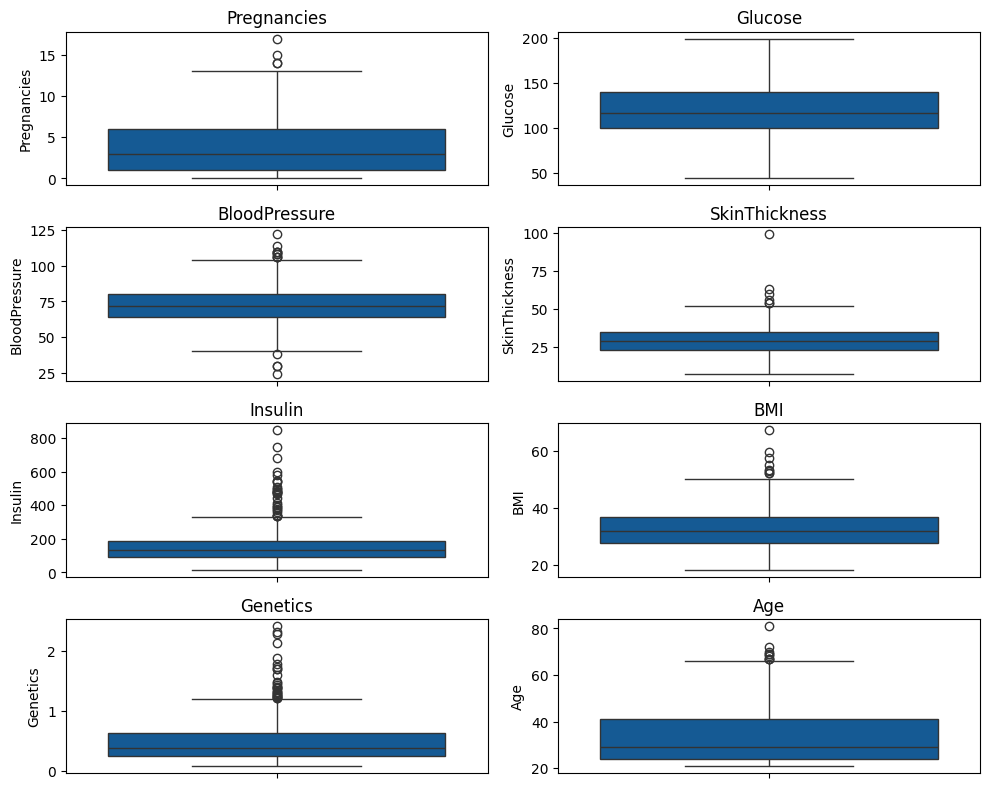

In [ ]:
colunas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Genetics', 'Age']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8))
f_axes = axes.flatten()

def grafico(df, ax, coluna, cor):
    fig = sns.boxplot(df, ax=ax, y=coluna, color=cor)
    fig.set_title(f'{coluna}')



for idx, col in enumerate(colunas):
    grafico(diabete_df, ax=f_axes[idx], coluna=col, cor='#005CA9')

plt.tight_layout()
plt.show()

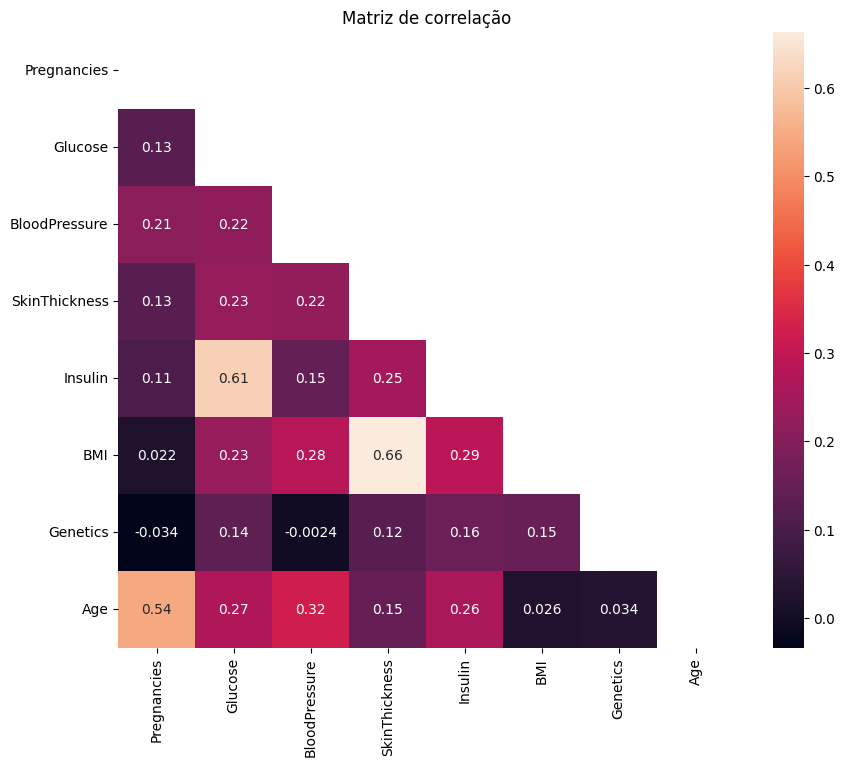

In [ ]:
plt.subplots(figsize=(10, 8))

corr = diabete_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, mask=mask, square=True, linewidths=0);
plt.title('Matriz de correlação');

Nota: Sem a imputação via KNNImputer, a correlação entre glicose e insulina é de 0.33%, com o uso da feature, quase que dobrou, para 61%

### 2.3 Seleção e criação de atributos:

Já que não há muitas correlações positivas com a variável 'glicose', precisamos pensar em possíveis combinações para aumentar a acurácia de um modelo de regressão:

 **Possíveis relações:**
 1. Massa corporal e pressão sanguínea - relação positiva
 2. Idade e insulina - relação negativa (quanto mais velho, menos insulina o corpo produz)
 3. Genética e insulina - relação positiva (determinados genes influenciam na capacidade de produção de insulina)

In [ ]:
'''
x < 18.5       - abaixo do peso
18.5 <= x < 25 - peso normal
25   <= x < 30 - obesidade grau 1
30   <= x < 40 - obesidade grau 2
x >= 40        - obesidade grau 3
'''

diabete_df['imc_classe'] = diabete_df['BMI'].apply(lambda x: 1 if x < 18.5 else 2 if x < 25 else 3 if x < 30 else 4 if x < 40 else 5)

In [ ]:
def criarVariavel(df, col1, col2, relacao, y_var='Glucose'):
    df = df.copy()
    df = df[[col1, col2, y_var]]

    # proporção
    df[f'ratio_{col1}_{col2}'] = df[col1] / (df[col2] + 1)

    if relacao == '+':
        # multiplicação / interação:
        df[f'mult_{col1}_{col2}'] = df[col1] * df[col2]
        # logartimo em combinação
        df[f'log_{col1}_{col2}'] = np.log(df[col1] + 1) + np.log(df[col2] + 1)
        # raiz quadrada
        df[f'sqrt_{col1}_{col2}'] = np.sqrt(df[col1] * df[col2])
    elif relacao == '-':
        # subtração
        df[f'sub_{col1}_{col2}'] = df[col1] - np.log(df[col2] + 1)
        # reflexão
        df[f'ref'] = df[col2].max() - df[col2] + 1
        df[f'ref_{col1}_{col2}'] = np.log(df[col1] + 1) * np.log(df['ref'])
        # mult_negativa
        df[f'mult_neg_{col1}_{col2}'] = np.log(df[col1] + 1) * (-np.log(df[col2] + 1))

    return df.corr()[y_var]

In [ ]:
criarVariavel(diabete_df, 'BMI', 'BloodPressure', '+')

,Glucose
BMI,0.231400
BloodPressure,0.218937
Glucose,1.000000
ratio_BMI_BloodPressure,0.036892
mult_BMI_BloodPressure,0.271859
log_BMI_BloodPressure,0.286496
sqrt_BMI_BloodPressure,0.281482


In [ ]:
criarVariavel(diabete_df, 'imc_classe', 'BloodPressure', '+')

,Glucose
imc_classe,0.242019
BloodPressure,0.218937
Glucose,1.000000
ratio_imc_classe_BloodPressure,0.075027
mult_imc_classe_BloodPressure,0.287700
log_imc_classe_BloodPressure,0.290736
sqrt_imc_classe_BloodPressure,0.289571


In [ ]:
criarVariavel(diabete_df, 'Age', 'Insulin', '-')

,Glucose
Age,0.266909
Insulin,0.612639
Glucose,1.000000
ratio_Age_Insulin,-0.372974
sub_Age_Insulin,0.239441
ref,-0.612639
ref_Age_Insulin,0.076831
mult_neg_Age_Insulin,-0.581197


In [ ]:
criarVariavel(diabete_df, 'Genetics', 'Insulin', '+')

,Glucose
Genetics,0.137327
Insulin,0.612639
Glucose,1.000000
ratio_Genetics_Insulin,-0.116940
mult_Genetics_Insulin,0.383787
log_Genetics_Insulin,0.622632
sqrt_Genetics_Insulin,0.467528


As funções de logaritmo em classes de IMC e pressão sanguínea e em genética e insulina ajudaram na média geral de correlação com a variável glicose (juntas, as duas variáveis aumentaram suas correlações)

In [ ]:
diabete_df['log_imc_classe_bp'] = np.log(diabete_df.imc_classe+1) + np.log(diabete_df.BloodPressure+1)
diabete_df['log_genetics_insulin'] = np.log(diabete_df.Genetics+1) + np.log(diabete_df.Insulin+1)

Testando uma nova variável logartimica com idade, número de gravidez e dobra cutânea da pele

In [ ]:
diabete_df['log_age_preg_st'] = np.log(diabete_df.Age+1) + np.log(diabete_df.Pregnancies+1) + np.log(diabete_df.SkinThickness+1)

In [ ]:
novo_df = diabete_df[['log_imc_classe_bp','log_genetics_insulin', 'log_age_preg_st', 'Glucose']]
novo_df.head(3)

,log_imc_classe_bp,log_genetics_insulin,log_age_preg_st,Glucose
0,5.899897,6.072862,9.461255,148.0
1,5.590987,4.610301,7.560080,85.0
2,5.273000,5.829195,9.098257,183.0


## 3. Criando modelo de regressão:

Pressupostos:

1. Relação linear entre variáveis independentes e dependentes.
2. Sem presença de outliers.
3. Passar no teste de homocedasticidade.
4. Ausência de multicolinearidade e autocorrelação.

In [ ]:
# Nota: converti a variável de glicose para a sua raíz quadrada para tentar melhorar o cenário da homocedasticidade
novo_df.Glucose = np.sqrt(novo_df.Glucose)
X = novo_df.drop(columns=['Glucose'])
y = novo_df.Glucose

/tmp/ipython-input-2562823082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novo_df.Glucose = np.sqrt(novo_df.Glucose)


### 3.1 Regressão Linear Múltipla:

#### 3.1.1 Criação:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

In [ ]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

In [ ]:
residuos = y_test - y_pred

In [ ]:
print(f'Intercepto: {linreg.intercept_}')
print(f'Coeficientes: {linreg.coef_}')

Intercepto: 1.6277785623691496
Coeficientes: [0.41040047 1.23544344 0.06013078]


In [ ]:
r2_score(y_test, y_pred)

0.4344498418008984

#### 3.1.2 Relação Linear:

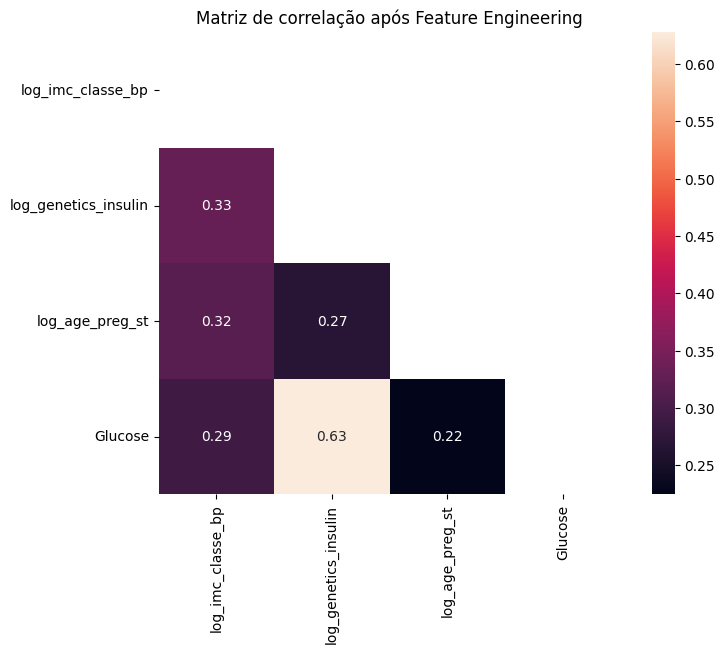

In [ ]:
plt.subplots(figsize=(8, 6))

corr = novo_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, mask=mask, square=True, linewidths=0);
plt.title('Matriz de correlação após Feature Engineering');

#### 3.1.3 Outliers:

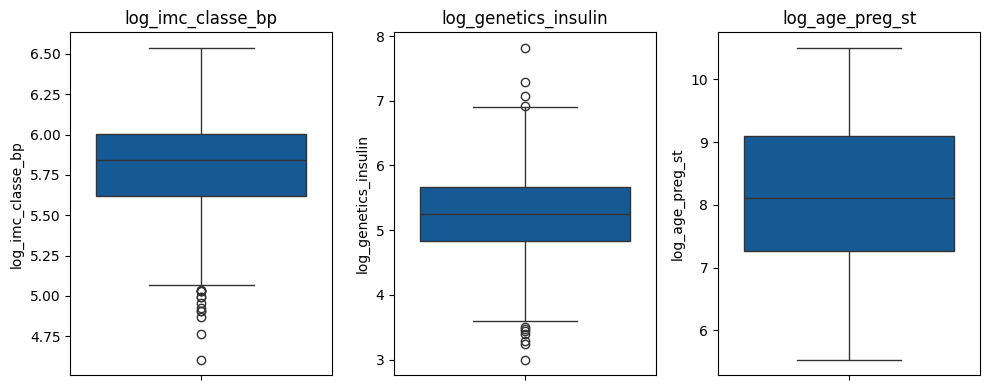

In [ ]:
novas_colunas = novo_df.columns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
f_axes = axes.flatten()

def grafico(df, ax, coluna, cor):
    fig = sns.boxplot(df, ax=ax, y=coluna, color=cor)
    fig.set_title(f'{coluna}')

for idx, col in enumerate(novas_colunas[0:-1]):
    grafico(novo_df, ax=f_axes[idx], coluna=col, cor='#005CA9')

plt.tight_layout()
plt.show()

A 1ª e a 2ª colunas ainda tem outliers, ainda que poucos em relação a antes, podendo impactar a previsão do modelo

#### 3.1.4 Homocedasticidade:

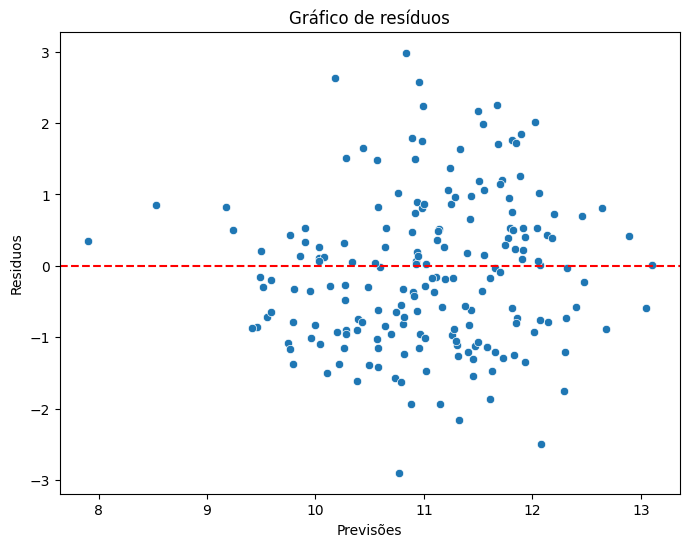

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Previsões")
plt.ylabel("Residuos")
plt.title("Gráfico de resíduos")
plt.show()

In [ ]:
# O teste de Breusch-Pagan precisa de uma constante:
X_com_constante = sm.add_constant(x_train)

linreg_treino = LinearRegression()
linreg_treino.fit(x_train, y_train)
previsao_treino =- linreg_treino.predict(x_train)
residuos_treino = y_train - previsao_treino

teste_breauschpagan = sms.het_breuschpagan(residuos_treino, X_com_constante)


print('p-value: ', teste_breauschpagan[1])
print('f_pvalue:', teste_breauschpagan[3])

p-value:  7.732369041718241e-89
f_pvalue: 4.6801355057694884e-155


In [ ]:
if teste_breauschpagan[1] < 0.05:
    print('Não é homocedástico')
else:
    print('É homocedástico')

Não é homocedástico


#### 3.1.5 Multicolinearidade e autocorrelação:

In [ ]:
vif_data = pd.DataFrame()
vif_data["features"] = X_com_constante.columns
vif_data["VIF"] = [variance_inflation_factor(X_com_constante.values, i) for i in range(len(X_com_constante.columns))]

print(vif_data)

               features         VIF
0                 const  371.873275
1     log_imc_classe_bp    1.210013
2  log_genetics_insulin    1.151053
3       log_age_preg_st    1.142366


In [ ]:
# Autocorrelação:
print(durbin_watson(residuos_treino))

0.015101010459233944


De acordo com a documentação do stats models:

- Um VIF de 5 ou mais já indica multicolinearidade.
- Durbin Watson estará sempre entre 0 e 4.
   - Quanto mais próxima de 0 - correlação serial positiva.
   - Quanto mais próxima de 4 - correlação serial negativa.

#### 3.1.6 Conclusão sobre Regressão Linear Múltipla:

**NÃO** foi validado o modelo de regressão linear múltipla, pois há diversos fatores de comprovam que, para prever a glicose, ele é ineficaz, mesmo com a utilização de técnicas de tratamento realizadas. Pode ser que utilizando outras técnicas como binning, possa ser mais eficaz, todavia, as quantidades de dados zerados criados artificialmente, as baixas correlações naturais com glicose e a quantidade de outliers ainda persistem, mesmo após o treinamento. No geral, a baixa assertividade não compensa o uso desse tipo de regressão, mesmo através de outras técnicas.